#**<font color='red'>MAKE A COPY TO YOUR GOOGLE DRIVE </font>**
Please make a copy, by navigating to **File > Save a copy in Drive**. This is important as you may lose your progress otherwise.

Once completed, please download as a Python (.py) file and submit on Gradescope (navigate to **File > Download > Download .py**). The file name should be **pset4.py**.


Make sure as you are working through the notebook, you run all the cells as you go along (otherwise your code may produce errors or not work properly). Additionally, your code cells may de-load if the session has been running for too long; please periodically restart your runtime / run all your cells.

In completing the assignment, please complete the functions / classes / variables. Do **NOT** change the names of existing functions / classes / variables and their signature / input (or re-assign / redefine them) as this is what Gradescope parses for. Lastly, do not include or import additional libraries beyond the ones provided for the final submission (as Gradescope will reject them).

# PSET4: Computer Vision (85 pts)

In this problem set, you'll explore topics in Computer Vision. In particular, you'll work the [Canny Edge Detection algorithm](https://drive.google.com/file/d/1OvRqa00YtWUclyyaeP8OX4m4_5plTEYh/view?usp=sharing), a foundational computational technique for image processing.

In [138]:
### DO NOT CHANGE ###
# importing the libraries (do not remove or add libraries)
import numpy as np

## Background

In this problem set, you will implement parts of the Canny Edge Detection algorithm from scratch using the NumPy library. Your Canny Edge Detector will take a *grayscale* image and return the image with its edges detected (i.e., apply the canny edge detection algorithm on the image).

Note: the reason for the emphasis on *grayscale* is that the original Canny Edge detection is defined for grayscale images. There is research on expanding to color images, such as this paper: [An improved Canny edge detection algorithm for color image](https://drive.google.com/file/d/1tW1b5B95Isc2DyLe0Y6Cv5WzeZ8TN-ZU/view?usp=sharing)

There are various versions and nuances on the Canny Edge Detection algorithm, so we'll provide some more, explicit details on the mechanics of the algorithm.

At a high level, the steps of the Canny Edge Detection algorithm are:

1.   Reduce the noise using a Gaussian Kernel / Convolution (pre-filter on the image)
2.   Compute the image gradients (use a gradient approximation operator / kernel / filter)
3.   Apply Non-Maximum Suppression (NMS) which filters out noise around the edges / keeps the maxima points
4.   Apply 2-stage thresholding to remove disconnected weak edges and connect strong edges with adjacent weak edges (hysteresis)

### Step 1: Noise Reduction with the Gaussian Kernel

The gaussian kernel is defined by this function:

\begin{align}
G_\sigma = \frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}
\end{align}

The $\sigma$ parameter is the strength of the Gaussian blur. Additionally, the Gaussian kernel is defined by its size $n$ which dictate it's dimension (the bigger the size, the stronger the Gaussian kernel will be). The value of $n$ is an odd number and indicates that the Gaussian kernel will be size $n \times n$. For your implementation, $\sigma$ and $n$ will be two parameters (they will be called `s` and `n` in the function signatures, respectively).

After we have our Gaussian kernel, we convolve it with the image. To preserve the original dimensions of the image, we should use padding at the boundaries / edges. To avoid our Canny Edge Detection algorithm from picking up false edges at the boundaries of the image, we will extend the image by using pixels at the image boundary, meaning that the extra pixels we pad to the image will take the value of the pixels from the nearest boundary. For pixels padded to the corner, it will take the value of the nearest corner pixel. This type of padding is called nearest neighbor padding / interpolation. By padding our image in this fashion, we avoid creating false spikes in our image pixel data (e.g., consider how padding with zeroes might lead to false edges at the boundary of the image since it will look like the image went from zero to some potentially high pixel value).


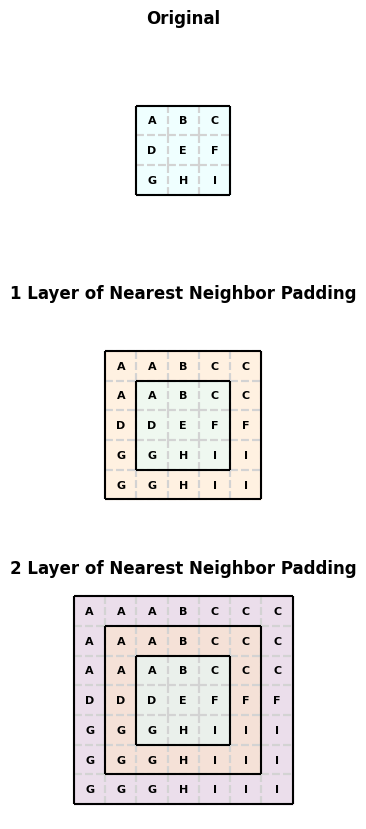

In [139]:
#@title Example Nearest Neighbor Padding
if __name__ == "__main__":
    import numpy as np
    import matplotlib.pyplot as plt

    images = [
        [
            ["A", "B", "C"],
            ["D", "E", "F"],
            ["G", "H", "I"],
        ],
        [
            ["A", "A", "B", "C", "C"],
            ["A", "A", "B", "C", "C"],
            ["D", "D", "E", "F", "F"],
            ["G", "G", "H", "I", "I"],
            ["G", "G", "H", "I", "I"],
        ],
        [
            ["A", "A", "A", "B", "C", "C", "C"],
            ["A", "A", "A", "B", "C", "C", "C"],
            ["A", "A", "A", "B", "C", "C", "C"],
            ["D", "D", "D", "E", "F", "F", "F"],
            ["G", "G", "G", "H", "I", "I", "I"],
            ["G", "G", "G", "H", "I", "I", "I"],
            ["G", "G", "G", "H", "I", "I", "I"],
        ]
    ]
    titles = [
        "Original",
        "1 Layer of Nearest Neighbor Padding",
        "2 Layer of Nearest Neighbor Padding",
    ]
    colors = [
        "lightcyan",
        "bisque",
        "thistle"
    ]
    fig_scale = 0.4
    canvas_buffer = 0.5

    original_img_height = len(images[0])
    original_img_width = len(images[0][0])
    canvas_height = len(images[-1])
    canvas_width = len(images[-1][0])

    fig_width = canvas_width
    fig_height = len(images) * fig_width
    fig, axs = plt.subplots(
        3, 1, figsize=(fig_scale * fig_width, fig_scale * fig_height)
    )

    for img, title, ax in zip(images, titles, axs):
        ax.set_title(title, weight="bold")
        ax.set_xlim(0 - canvas_buffer, canvas_width + canvas_buffer)
        ax.set_ylim(0 - canvas_buffer, canvas_height + canvas_buffer)
        ax.axis("off")

        img_height, img_width = len(img), len(img[0])
        x_start = (canvas_width - img_width) // 2
        y_start = (canvas_height - img_height) // 2
        x_end = x_start + img_width
        y_end = y_start + img_height

        # add base dashlines
        for y in range(y_start, y_end):
            for x in range(x_start, x_end):
                ax.hlines(y, x, x+1, color="lightgray", linestyle="--")
                ax.hlines(y+1, x, x+1, color="lightgray", linestyle="--")
                ax.vlines(x, y, y+1, color="lightgray", linestyle="--")
                ax.vlines(x+1, y, y+1, color="lightgray", linestyle="--")

        # add x solid boundary and color
        for offset, x in enumerate(range(x_start, x_end)):
            if x - original_img_width < 0:
                # solid boundary
                ax.vlines(
                    x, y_start + offset, y_end - offset,
                    color="black", linestyle="-"
                )
                ax.vlines(
                    canvas_width - x, y_start + offset, y_end - offset,
                    color="black", linestyle="-"
                )

                # color
                color_region = np.linspace(x, canvas_width - x, 100)
                ax.fill_between(
                    color_region,
                    (y_start + offset) * np.ones_like(color_region),
                    (y_end - offset) * np.ones_like(color_region),
                    where=(color_region >= y_start + offset) & (color_region <= y_end - offset),
                    color=colors[::-1][x], alpha=0.5
                )

        # add y solid boundary
        for offset, y in enumerate(range(y_start, y_end)):
            if y - original_img_height < 0:
                ax.hlines(
                    y, x_start + offset, x_end - offset,
                    color="black", linestyle="-"
                )
                ax.hlines(
                    canvas_height - y, x_start + offset, x_end - offset,
                    color="black", linestyle="-"
                )

        # add labels
        for y in range(y_start, y_end):
            for x in range(x_start, x_end):
                ax.text(
                    x + 0.5, y + 0.5, img[y_end - y - 1][x - x_start],
                    ha="center", va="center",
                    color="black",
                    fontsize=8, fontweight="bold"
                )

    plt.tight_layout()
    plt.show()

#### Step 2: Compute the Image Gradients

We need gradients of the image to see where edges are because edges are where pixel values rapidly change value (so their rate of change is high). Unfortunately, we can't mathematically define exact gradients for discrete values such as pixel values. However, we can approximate them. For images, this can be done by using filters / operators such as Sobel, Prewitt, and/or Roberts. These filters / operators define kernels to calculate gradients in the $x$ and $y$ directions - with this information, the true gradient magnitude and direction can be estimated.

It should also be noted that there are different variants of these filters, such as different sizes (e.g., $3 \times 3$ Sobel vs $5 \times 5$ Sobel, etc.). For your implementation, you'll work with these variants of the operators.

For Sobel,

$$
G_x = \begin{bmatrix}
    1 & 0 & -1 \\
    2 & 0 & -2 \\
    1 & 0 & -1
\end{bmatrix},
G_y = \begin{bmatrix}
    1 & 2 & 1 \\
    0 & 0 & 0 \\
    -1 & -2 & -1
\end{bmatrix}
$$

For Prewitt,

$$
G_x = \begin{bmatrix}
    1 & 0 & -1 \\
    1 & 0 & -1 \\
    1 & 0 & -1
\end{bmatrix},
G_y = \begin{bmatrix}
    1 & 1 & 1 \\
    0 & 0 & 0 \\
    -1 & -1 & -1
\end{bmatrix}
$$

For Roberts,

$$
G_x = \begin{bmatrix}
    1 & 0 \\
    0 & -1
\end{bmatrix},
G_y = \begin{bmatrix}
    0 & 1 \\
    -1 & 0
\end{bmatrix}
$$

Where $G_x$ is the matrix to approximate gradients in the $x$ direction, and $G_y$ is the matrix to approximate gradients in the $y$ direction. Similar to the Gaussian kernel from step 1, we convolve $G_x$ and $G_y$ with the image. To perserve the original dimensions of the image, we should use padding at the boundaries / edges. After convolving the image with the kernels, $G_x$ and $G_y$, we will have $I_x$ which is the image gradient along the X direction and $I_y$ which is the image gradient along the Y direction. To find the overall gradient magnitude and direction, we can use basic trignometry and arrive at:

\begin{align}
|\nabla I| &= \sqrt{I_x^2+I_y^2} \\
\Theta_{\nabla I} &= \text{atan2}(I_y, I_x)
\end{align}

The first equation is for the magnitude of the gradient and the second equation is for the angle that the gradient is pointing in.

For your implementation, `gradient_kernel` will be a parameter. It will be a string flag that will equal `sobel`, `prewitt`, or `roberts` indicating which gradient approximation kernel should be used (e.g., if `gradient_kernel = sobel`, use the sobel operator defined above for gradient calculations).

#### Step 3: Non-Maximum Suppression (NMS) for Image Gradients


Non-Maximum Suppression (NMS) is a crucial step where we filter away all the noisy gradient values and find the places where the gradients truly represent edges. At a high level, NMS looks along the direction that each pixel's gradient points to, and sees if the point has the maximal gradient value along that direction amongst its neighbors (i.e., nearby pixels). If it is maximal, it stays, otherwise it is suppressed (i.e., zero-ed out).

When the gradient points to a neighboring pixel, such as at a $45°$ or $90°$ angle which represents pointing to it's north-east pixel neighbor and it's east pixel neighbor, respectively, it's very clear to which gradient values should be compared. For example, if the gradient points at a $45°$ angle, we would compare the gradient values along that direction, meaning we'd compare gradient values with the north-east pixel and south-west pixel, as those neigboring pixels are along the direction of the gradient. However, when the gradient points in a direction that is between pixels, such as $85°$, then we don't have a direct pixel neighbor to compare with - to resolve this we will either approximate, which means we use the nearest pixel neighbor in that direction, or interpolate what the gradient value would be in that direction.

For this implementation, we'll stick with approximating with the nearest neighbor in the direction of the gradient. From the earlier step, we stated that the angle of the gradient can be determined by the $\text{atan2}$ function. This function returns values between $[-180°, 180°]$.

To make the implementation easier, we can exploit the symmetry with angles. We can relate a negative gradient angle with a positive gradient angle. For example, if the gradient angle was $-135°$, it is along the same axis as a gradient with angle $45°$. Thus, to convert our negative gradients to their corresponding positive gradient, we add $180°$. Thus, our new domain after this transformation is $[0°, 180°]$. Note: although this transformation flips the direction for gradients with negative angles, it doesn't really affect the Canny Edge Detection algorithm because the algorithm compares gradient values along the direction axis (so it compares both the positive and negative direction).

After the above transformation, we'll take those angle values and round it to a value so that the gradient points in a direction of neighboring pixel:
- Gradient angles in $[0°, 22.5°)$ or $[157.5°, 180°]$ will map to $0°$ meaning the gradient points along the east and west direction; thus the gradient value of the pixel should be compared with its east and west neighbor; if it's greater than it's east and west neighbor, it stays, otherwise it's suppressed and it's gradient value goes to zero.
- Gradient angles in $[22.5°, 67.5°)$ will map to $45°$ meaning the gradient points along the north-east and south-west direction; thus the gradient value of the pixel should be compared with its north-east and south-west neighbor; if it's greater than it's north-east and south-west neighbor, it stays, otherwise it's suppressed and it's gradient value goes to zero.
- Gradient angles in $[67.5°, 112.5°)$ will map to $90°$ meaning the gradient points along the north and south direction; thus the gradient value of the pixel should be compared with its north and south neighbor; if it's greater than it's north and south neighbor, it stays, otherwise it's suppressed and it's gradient value goes to zero.
- Gradient angles in $[112.5°, 157.5°)$ will map to $135°$ meaning the gradient points along the north-west and south-east direction; thus the gradient value of the pixel should be compared with its north-west and south-east neighbor; if it's greater than it's north-west and south-east neighbor, it stays, otherwise it's suppressed and it's gradient value goes to zero.

Note: in this implementation, when we think about a pixel's neighbors, we are look at the $3 \times 3$ window about the pixel (where the pixel is in the center). However, we can also implement this by looking at a bigger window of neighbors such as a $5\times5$ window. For this implementation. we'll only stick with the $3 \times 3$ window.

After this step, a bunch of gradients will go to zero and we'll be left with only gradients that were maximal (in their $3 \times 3$ neighborhood of pixels).

#### Step 4: Two-Stage Hysteresis

The remaining gradients will still be noisy. To handle that noise, we'll apply two stage hysteresis / filtering. We'll define a `high_threshold` and `low_threshold` where `high_threshold` > `low_threshold`. If a pixel value's gradient is above `high_threshold`, it's a strong edge and is kept. If a pixel value's gradient is less than the `low_threshold`, then it's suppressed (goes to zero). If a pixel value's is between the `low_threshold` and `high_threshold` inclusive, then it's considered a weak edge. A weak edge will only remain if one of it's adjacent neigbors (for this implementation, it is the $3 \times 3$ window centered on the pixel) is marked as a strong edge.

Since the actual gradient values are arbitrary (in the sense that the range of gradient values will be different for different images and gradient approximation kernel), we'll standardize them at this point so that the `high_threshold` and `low_threshold` have a standard range for any image or gradient approximation kernel. This is done by scaling the gradient value such that all the gradient values are now numbers between 0 to 1 (where the smallest gradient value mapped to 0 and the largest gradient value mapped to 1). This can be acheived by taking each gradient value, subtracting the smallest gradient value and then dividing by the difference between largest and smallest gradient value (this effectively shifts the gradient range to start at zero and scales it to be between 0 and 1). With this, the `high_threshold` and `low_threshold` parameters will be float numbers between `0` and `1`.

The pixel values that correspond to an edge will stay and everything else will go to zero. In the end, we'll be left with a binary map of which pixels correspond to edges.

For your implementation, `high_threshold` and `low_threshold` will be parameters.

#### Results and Other Notes

The return value should be a matrix that is the original dimension as the input image `img`. Furthermore, the matrix should be matrix of `0` and `1` where `0` represents no edge and `1` represents an edge.

Some notes:
- Be wary of boundary / corners of the image - you'll need to have special logic / exceptions to handle them
- Pay attention to the shape of the matrices and units (i.e., degrees vs radians)
- For numeric stability, a common pre-processing step in computer vision is to normalize our images, such that values fall between 0 and 1. Since pixel values can take on values between 0 to 255 inclusive, a simple way to normalize images is to rescale the pixel values by a factor of $\frac{1}{255}$

## Utility Functions (25 pts)

In this section, you'll create several utility (helper) functions that maybe useful as you work through implementing the Canny Edge Detection algorithm.

### Gaussian Function (5 pts)

Implement the gaussian function used for creating the gaussian blur kernel where `s` is the $\sigma$, `x` is $x$, and `y` is $y$. Assume $\sigma > 0$. For reference, here's the gaussian function:

\begin{align}
G_\sigma(x, y) = \frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}
\end{align}

**Hint**: Use [`np.pi`](https://numpy.org/doc/stable/reference/constants.html) and [`np.exp`](https://numpy.org/doc/stable/reference/generated/numpy.exp.html).

#### Examples

##### Example 1

```python
s = 1
x = 0
y = 0

gaussian_function(s, x, y) = 0.15915494309189535
```
**Explanation**: Applying the formula, we have $G_1(0, 0) = \frac{1}{2\pi(1^2)}e^{-\frac{(0^2)+(0^2)}{2(1^2)}} = 0.15915494309189535$

##### Example 2



```python
s = 2
x = 1
y = 0

gaussian_function(s, x, y) = 0.035113436077406295
```
**Explanation**: Applying the formula, we have $G_2(1, 0) = \frac{1}{2\pi(2^2)}e^{-\frac{(1^2)+(0^2)}{2(2^2)}} = 0.035113436077406295$

#### <mark>Implementation</mark>


In [140]:
def gaussian_function(s: float, x: int, y: int) -> float:
    return (1 / (2 * np.pi * (s ** 2))) * np.exp(-(x**2 + y**2) / (2 * (s**2)))

### Nearest Neighbor Padding (5 pts)

Given a grayscale image matrix `img`, with height `H` and width `W` (i.e., shape `(H, W)`), extend the image with 1 layer of padding around the image. Extend the image by using pixels at the image boundary, meaning that the extra pixels we pad to the image will take the value of the pixels from the nearest boundary. For pixels padded to the corner, it will take the value of the nearest corner pixels.

**Hint**: Use [`.shape`](https://numpy.org/doc/stable/reference/generated/numpy.shape.html) to find the height and width of the image and then extend accordingly.

#### Examples

##### Example 1

```python
img = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

one_layer_nearest_neighbor_padding(img) = np.array([
    [1, 1, 2, 3, 3],
    [1, 1, 2, 3, 3],
    [4, 4, 5, 6, 6],
    [7, 7, 8, 9, 9],
    [7, 7, 8, 9, 9]
])
```

**Explanation**: Extend the boundaries of the image with pixel value closest to the boundaries. For corner pixels, use the nearest corner pixel.

##### Example 2

```python
img = np.array([
    [1,  2,  3,  4],
    [5,  6,  7,  8],
    [9, 10, 11, 12]
])

one_layer_nearest_neighbor_padding(img) = np.array([
    [1,  1,  2,  3,  4,  4],
    [1,  1,  2,  3,  4,  4],
    [5,  5,  6,  7,  8,  8],
    [9,  9, 10, 11, 12, 12],
    [9,  9, 10, 11, 12, 12]
])
```

**Explanation**: Extend the boundaries of the image with pixel value closest to the boundaries. For corner pixels, use the nearest corner pixel.

#### <mark>Implementation</mark>

In [141]:
def one_layer_nearest_neighbor_padding(img: np.ndarray) -> np.ndarray:
    H, W = img.shape
    padded_img = np.zeros((H + 2, W + 2), dtype=img.dtype)

    padded_img[1:-1, 1:-1] = img

    padded_img[0, 1:-1] = img[0, :]
    padded_img[-1, 1:-1] = img[-1, :]
    padded_img[1:-1, 0] = img[:, 0]
    padded_img[1:-1, -1] = img[:, -1]

    padded_img[0, 0] = img[0, 0]
    padded_img[0, -1] = img[0, -1]
    padded_img[-1, 0] = img[-1, 0]
    padded_img[-1, -1] = img[-1, -1]

    return padded_img

### Convolve (5 pts)

Given a grayscale image matrix `img`, with height `H` and width `W` (i.e., shape `(H, W)`), and a `kernel`, apply convolution on the image `img` with the `kernel`. Ensure that the resulting image is the same height `H` and width `W` by using the padding scheme described for `one_layer_nearest_neighbor_padding`. Note: depending on the `kernel` size, additional layers of padding might be required. Furthermore, assume the shape of the `kernel` is $n \times n$ where $n$ is an odd, positive number (i.e. square matrix with odd-numbered dimensions).

Note: there are implementations of 2D convolution in popular libraries, such as `scipy`, however the spirit of this problem is to implement it from scratch using `numpy`. Additionally, the NumPy library does have a convolve function, [`np.convolve`](https://numpy.org/doc/2.0/reference/generated/numpy.convolve.html), however it is intended for 1D convolution (i.e., 1-dimensional signal / data).

**Hint**: You will need to loop over each pixel in the image and then loop over the window around the pixel to perform convolution. To handle the boundaries of the image, you need a sufficient amount of padding, so use your `one_layer_nearest_neighbor_padding` implementation an appropriate number of times (which will depend on the size of the kernel being used).

#### Examples

##### Example 1

```python
img = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])
kernel = np.array([
    [ 4,  0, -3],
    [-3,  2,  2],
    [-2,  1,  1]
])

convolve(img, kernel) = np.array([
    [ 2,  5,  7],
    [ 5,  8, 10],
    [11, 14, 16]
])
```

**Explanation**: Applying the kernel at each pixel in the `img` gives us the final result. For the center pixel, no padded values are needed since the `kernel` is $3 \times 3$. For the corner / boundary pixels, padded values were used (need one layer of padding).

##### Example 2

```python
img = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])
kernel = np.array([
    [ 4,  0, -3,  2,  3],
    [-3,  2,  2,  1,  0],
    [-2,  1,  1,  2, -8],
    [-1,  3, -6,  7,  1],
    [ 2,  1,  0,  0,  1]
])

convolve(img, kernel) = np.array([
    [52, 58, 59],
    [46, 52, 53],
    [34, 40, 41]
])
```

**Explanation**: Applying the kernel at each pixel in the `img` gives us the final result. For the center pixel, padded values are needed since the `kernel` is $5 \times 5$, so one layer of padded values were used. For the corner / boundary pixels, padded values were used (need two layers of padding).

#### <mark>Implementation</mark>

In [142]:
def convolve(img: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    H, W = img.shape
    kH, kW = kernel.shape

    padded_img = img.copy()
    for i in range(kH // 2):
      padded_img = one_layer_nearest_neighbor_padding(padded_img)

    output = np.zeros((H, W), dtype=img.dtype)

    for i in range(H):
      for j in range(W):
        img_region = padded_img[i:i + kH, j:j + kW]
        output[i, j] = np.sum(img_region * kernel)

    return output

### Normalize Image (5 pts)

Given a grayscale image matrix `img`, with height `H` and width `W` (i.e., shape `(H, W)`), normalize the pixel values. The resulting image will take values between 0 and 1. The way to normalize an image is to scale each pixel in the image by $\frac{1}{255}$.

**Hint**: Leverage NumPy's [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) feature.

#### Examples

##### Example 1

```python
img = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

normalize_image(img) = np.array([
    [0.00392156862745098, 0.00784313725490196, 0.011764705882352941],
    [0.01568627450980392, 0.01960784313725490, 0.023529411764705882],
    [0.02745098039215686, 0.03137254901960784, 0.035294117647058820]
])
```

**Explanation**: normalize the `img` matrix by dividing each value by 255.

##### Example 2

```python
img = np.array([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12]
])

normalize_image(img) = np.array([
    [0.00392156862745098, 0.007843137254901960, 0.011764705882352941, 0.015686274509803920],
    [0.01960784313725490, 0.023529411764705882, 0.027450980392156862, 0.031372549019607840],
    [0.03529411764705882, 0.039215686274509800, 0.043137254901960784, 0.047058823529411764]
])
```

**Explanation**: normalize the `img` matrix by dividing each value by 255.

#### <mark>Implementation</mark>

In [143]:
def normalize_image(img: np.ndarray) -> np.ndarray:
    return img / 255

### Rescale Matrix (5 pts)

Given a 2D matrix, `M`, with height `H` and width `W` (i.e., shape `(H, W)`), rescale the values such that they fall between 0 and 1 (where the smallest value mapped to 0 and the largest value mapped to 1). This can be acheived by taking each value, subtracting the smallest value and then dividing by the difference between largest and smallest value (this effectively shifts the range to start at zero and scales it to be between 0 and 1).

**Hint**: Use [`np.min`](https://numpy.org/doc/stable/reference/generated/numpy.min.html) and [`np.max`](https://numpy.org/doc/stable/reference/generated/numpy.max.html).

#### Examples

##### Example 1

```python
M = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

rescale_matrix(M) = np.array([
    [  0.0, 0.125,  0.25],
    [0.375,   0.5, 0.625],
    [ 0.75, 0.875,   1.0]
])
```

**Explanation**: The smallest value in `M` is 1 and the largest value in `M` is 9. The difference between the largest and smallest value is 8. To get our rescaled matrix, we subtract the smallest value, 1, from every cell and then divide by difference, 8.

##### Example 2

```python
M = np.array([
    [-4, -3, -2, -1],
    [ 0,  1,  2,  3],
    [ 4,  5,  7,  6]
])

rescale_matrix(M) = np.array([
    [                 0, 0.09090909090909091, 0.18181818181818182, 0.2727272727272727],
    [0.3636363636363636, 0.45454545454545453, 0.54545454545454545, 0.6363636363636364],
    [0.7272727272727273, 0.81818181818181818,                   1, 0.90909090909090909]
])
```

**Explanation**: The smallest value in `M` is -4 and the largest value in `M` is 7. The difference between the largest and smallest value is 11. To get our rescaled matrix, we subtract the smallest value, -4, from every cell and then divide by difference, 11. (Note: since the smallest value is a negative number, we're actually adding 4 to every value).

#### <mark>Implementation</mark>

In [144]:
def rescale_matrix(M: np.ndarray) -> np.ndarray:
  return (M - np.min(M)) / (np.max(M) - np.min(M))

## Step 1: Noise Reduction with the Gaussian Kernel (5 pts)

In this section, you'll implement functions for Step 1: Noise Reduction with the Gaussian.

### Gaussian Kernel (5 pts)

Create a `n` by `n` gaussian kernel with $\sigma =$ `s`. For this problem `n` will always be a positive, odd number. Assume $\sigma > 0$. The return type is `np.ndarray` with shape `(n,n)`.

**Hint**: Use your `gaussian_function` implementation from the Utilities section.

#### Examples

##### Example 1

```python
s = 1
n = 5

gaussian_kernel(s, n) = np.array([
    [0.002915024465028193, 0.013064233284684921, 0.02153927930184862, 0.013064233284684921, 0.002915024465028193],
    [0.013064233284684921, 0.058549831524319175, 0.09653235263005391, 0.058549831524319175, 0.013064233284684921],
    [0.021539279301848627, 0.096532352630053910, 0.15915494309189535, 0.096532352630053910, 0.021539279301848627],
    [0.013064233284684921, 0.058549831524319175, 0.09653235263005391, 0.058549831524319175, 0.013064233284684921],
    [0.002915024465028193, 0.013064233284684921, 0.02153927930184862, 0.013064233284684921, 0.002915024465028193]
])
```

**Explanation**: The kernel matrix is 5 by 5 since `n = 5`. The center of the matrix correspond to $G_{\sigma}(0, 0)$ where $\sigma = 1$ since `s = 1`, using the gaussian function defined earlier. The other entries are $G_{\sigma}(x, y)$ where $x$ and $y$ is the how far horizontally and vertically, respectively, it is from the center.

##### Example 2

```python
s = 2
n = 3

gaussian_kernel(s, n) = np.array([
    [0.030987498577413244, 0.035113436077406295, 0.030987498577413244],
    [0.035113436077406295, 0.039788735772973836, 0.035113436077406295],
    [0.030987498577413244, 0.035113436077406295, 0.030987498577413244]
])
```

**Explanation**: The kernel matrix is 3 by 3 since `n = 3`. The center of the matrix correspond to $G_{\sigma}(0, 0)$ where $\sigma = 2$ since `s = 2`, using the gaussian function defined earlier. The other entries are $G_{\sigma}(x, y)$ where $x$ and $y$ is the how far horizontally and vertically, respectively, it is from the center.

#### <mark>Implementation</mark>

In [145]:
def gaussian_kernel(s: float, n: int) -> np.ndarray:
    output = np.zeros((n, n))
    center = n // 2

    for i in range(n):
      for j in range(n):
        output[i, j] = gaussian_function(s, i - center, j - center)

    return output

### Noise Reduction Demo

After implementing all of the above functions, you can experiment with denoising an image with the Gaussian kernel on a sample image. Feel free to experiment with the the `s` and `n` parameter.

**Note**: Make sure to run all of the above cells in order for the demo to work as it assumes that the previous cells were ran. Additionally, validate your implementations are working, either by manually testing with the examples or automatically testing by submitting on Gradescope (which will run the example test cases and give feedback). The demo uses your implementations so errors in your implementation can cause the demo to not work. The demo also tries to give useful hints or pointers if there are issues on what the issue might be (however it may not always be accurate or perfect). If there are questions or issues, please reach out to the course staff by posting on Ed.

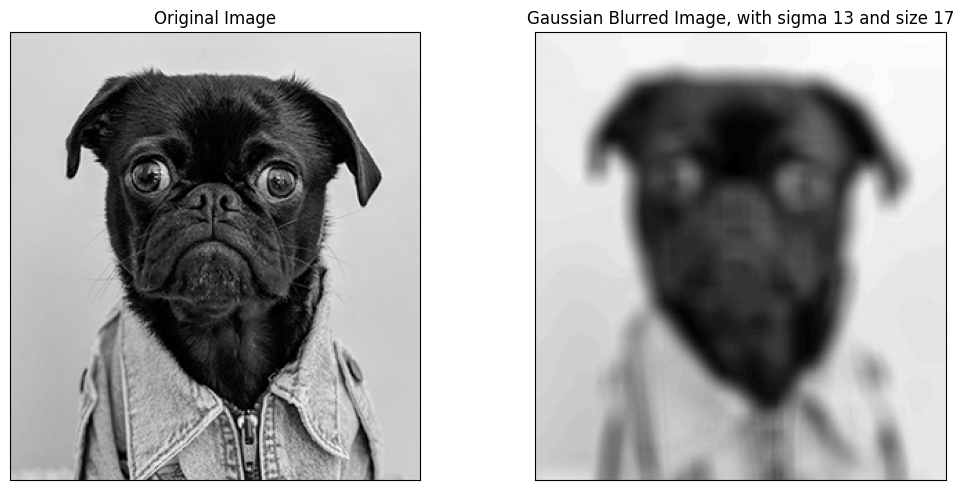

In [146]:
### DO NOT CHANGE ###
#@title Experiment with Gaussian Kernel { run: "auto" }
if __name__ == "__main__":
    import numpy as np

    # custom exception
    class StopExecution(Exception):
        """Custom execution handler."""
        def _render_traceback_(self):
            """Suppress long exception message."""
            pass

    # custom print statements
    def printRB(text: str) -> None:
        """Prints red and bold."""
        red_bold = "\033[1;31m"
        reset = "\033[0m"
        print(f"{red_bold}{text}{reset}")

    # custom error handling
    def validate_numpy_implementation(
            expected_shape: tuple, function: str, **kwargs
        ) -> np.ndarray:
        """Does numpy-related validation and error handling.

        Args:
            expected_shape: expected shape of the numpy array
            function: string name of the function
            **kwargs: parameters for the function

        Returns:
            The numpy array result if all the validation checks pass
        """
        try:
            result = eval(function)(**kwargs)
            assert result is not None, (
                f"The `{function}` function does not have a return value"
            )
            assert isinstance(result, np.ndarray), (
                f"The `{function}` function does not return a numpy array"
            )
            assert result.shape == expected_shape, (
                f"The `{function}` function should return a numpy array "
                f"with shape {expected_shape} but found shape: {result.shape}"
            )
            assert not np.any(result == None), (
                f"The `{function}` function should return a numpy array "
                f"with only numeric data but found `None` values"
            )
        except NameError as e:
            printRB(
                "ERROR: It appears that the previous code cells "
                f"were not executed; please run the above cells!\n"
                f"Encounter exception with message: {e}"
            )
            raise StopExecution
        except Exception as e:
            printRB(
                f"ERROR: Required implementation for `{function}` "
                "is incorrect or incomplete\nCheck your solution "
                "with the provided examples or validate with Gradescope\n"
                f"Encounter exception with message: {e}"
            )
            raise StopExecution
        return result

    # download the images
    import os
    import gdown

    file_id = "15HWhYP_Kjbsz5AusTuuZtLi9nmTGiviY"
    img_filepath = "/content/sample_image.jpg"

    if not os.path.exists(img_filepath):
        try:
            gdown.download(
                f"https://drive.google.com/uc?id={file_id}",
                img_filepath, quiet=True
            )
        except Exception as e:
            printRB(
                "ERROR: Could not download the file; "
                f"encounter exception with message: {e}"
            )
            raise StopExecution

    # parameters
    s = 13 #@param { type: "slider", min: 1, max: 20, step: 1}
    n = 17 #@param { type: "slider", min: 3, max: 25, step: 2}

    # process the image
    import cv2
    import matplotlib.pyplot as plt

    try:
        img = cv2.imread(img_filepath, cv2.IMREAD_COLOR)
    except Exception as e:
        printRB(
            "ERROR: Could not open the file; "
            f"encounter exception with message: {e}"
        )
        raise StopExecution

    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except Exception as e:
        printRB(
            "ERROR: Could not convert the image to grayscale; "
            f"encounter exception with message: {e}"
        )
        raise StopExecution


    kernel = validate_numpy_implementation(
        (n, n), "gaussian_kernel", s=s, n=n
    )
    gaussian_filtered_img = validate_numpy_implementation(
        img.shape, "convolve", img=img, kernel=kernel
    )

    try:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))
        for index, a in enumerate(ax):
            a.set_xticks([])
            a.set_yticks([])

        ax[0].imshow(img, cmap="gray")
        ax[0].set_title("Original Image")
        ax[1].imshow(gaussian_filtered_img, cmap="gray")
        ax[1].set_title(f"Gaussian Blurred Image, with sigma {s} and size {n}")
    except Exception as e:
        print(f"ERROR: Encountered issue with visualizing the results: {e}")
        raise StopExecution

    plt.tight_layout()
    plt.show()

## Step 2: Compute the Image Gradients (25 pts)

In this section, you'll implement functions for Step 2: Compute the Image Gradients.

### Gradients XY Sobel (5 pts)

Given an grayscale image matrix `img`, with height `H` and width `W` (i.e., shape `(H, W)`), determine the gradients in the `x` direction, $I_x$, and the gradients in the `y` direction, $I_y$, using convolution with the Sobel operator. Note: the output, $I_x$ and $I_y$, should be shape `(H, W)`.

Recall, the Sobel kernels are,
$$
G_x = \begin{bmatrix}
    1 & 0 & -1 \\
    2 & 0 & -2 \\
    1 & 0 & -1
\end{bmatrix},
G_y = \begin{bmatrix}
    1 & 2 & 1 \\
    0 & 0 & 0 \\
    -1 & -2 & -1
\end{bmatrix}
$$

**Hint**: Define the kernels as NumPy arrays inside the function and use your `convolve` implementation from the Utilities section.

#### Examples

##### Example 1

```python
img = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

gradients_x_sobel(img) = np.array([
    [-4, -8, -4],
    [-4, -8, -4],
    [-4, -8, -4]
])

gradients_y_sobel(img) = np.array([
    [-12, -12, -12],
    [-24, -24, -24],
    [-12, -12, -12]
])
```

**Explanation**: We convolve $G_x$ and $G_y$ for the sobel operator with the image.

##### Example 2

```python
img = np.array([
    [1,  2,  3,  4],
    [5,  6,  7,  8],
    [9, 10, 11, 12]
])

gradients_x_sobel(img) = np.array([
    [-4, -8, -8, -4],
    [-4, -8, -8, -4],
    [-4, -8, -8, -4]
])

gradients_y_sobel(img) = np.array([
    [-16, -16, -16, -16],
    [-32, -32, -32, -32],
    [-16, -16, -16, -16]
])

```

**Explanation**: We convolve $G_x$ and $G_y$ for the sobel operator with the image.

#### <mark>Implementation</mark>

Each function is worth 2.5 pts.

In [147]:
def gradients_x_sobel(img: np.ndarray) -> np.ndarray:
    kernel = np.array([
        [ 1,  0, -1],
        [ 2,  0, -2],
        [ 1,  0, -1]
    ])

    return convolve(img, kernel)

def gradients_y_sobel(img: np.ndarray) -> np.ndarray:
    kernel = np.array([
        [ 1,  2,  1],
        [ 0,  0,  0],
        [-1, -2, -1]
    ])

    return convolve(img, kernel)

### Gradients XY Prewitt (5 pts)

`gradients_xy_prewitt` (5 pts). Given an grayscale image matrix `img`, with height `H` and width `W` (i.e., shape `(H, W)`), determine the gradients in the `x` direction, $I_x$, and the gradients in the `y` direction, $I_y$, using convolution with the Prewitt operator. Note: the output, $I_x$ and $I_y$, should be shape `(H, W)`.

Recall, the Prewitt kernels are,
$$
G_x = \begin{bmatrix}
    1 & 0 & -1 \\
    1 & 0 & -1 \\
    1 & 0 & -1
\end{bmatrix},
G_y = \begin{bmatrix}
    1 & 1 & 1 \\
    0 & 0 & 0 \\
    -1 & -1 & -1
\end{bmatrix}
$$

**Hint**: Define the kernels as NumPy arrays inside the function and use your `convolve` implementation from the Utilities section.

#### Examples

##### Example 1

```python
img = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

gradients_x_prewitt(img) = np.array([
    [-3, -6, -3],
    [-3, -6, -3],
    [-3, -6, -3]
])

gradients_y_prewitt(img) = np.array([
    [ -9,  -9,  -9],
    [-18, -18, -18],
    [ -9,  -9,  -9]
])
```

**Explanation**: We convolve $G_x$ and $G_y$ for the prewitt operator with the image.

##### Example 2

```python
img = np.array([
    [1,  2,  3,  4],
    [5,  6,  7,  8],
    [9, 10, 11, 12]
])

gradients_x_prewitt(img) = np.array([
    [-3, -6, -6, -3],
    [-3, -6, -6, -3],
    [-3, -6, -6, -3]
])


gradients_y_prewitt(img) = np.array([
    [-12, -12, -12, -12],
    [-24, -24, -24, -24],
    [-12, -12, -12, -12]
])
```

**Explanation**: We convolve $G_x$ and $G_y$ for the prewitt operator with the image.

#### <mark>Implementation</mark>

Each function is worth 2.5 pts.

In [148]:
def gradients_x_prewitt(img: np.ndarray) -> np.ndarray:
    kernel = np.array([
        [ 1,  0, -1],
        [ 1,  0, -1],
        [ 1,  0, -1]
    ])

    return convolve(img, kernel)

def gradients_y_prewitt(img: np.ndarray) -> np.ndarray:
    kernel = np.array([
        [ 1,  1,  1],
        [ 0,  0,  0],
        [-1, -1, -1]
    ])

    return convolve(img, kernel)

### Gradients XY Roberts (5 pts)

`gradients_xy_roberts` (5 pts). Given an grayscale image matrix `img`, with height `H` and width `W` (i.e., shape `(H, W)`), determine the gradients in the `x` direction, $I_x$, and the gradients in the `y` direction, $I_y$, using convolution with the Roberts operator. Note: the output, $I_x$ and $I_y$, should be shape `(H, W)`.

Recall, the Roberts kernels are,
$$
G_x = \begin{bmatrix}
    1 & 0 \\
    0 & -1
\end{bmatrix},
G_y = \begin{bmatrix}
    0 & 1 \\
    -1 & 0
\end{bmatrix}
$$

Notice, the Roberts kernels are $2 \times 2$, which can make them hard to convolve with. To make the convolution behavior more nice, we can pad the Roberts kernels to make them $3 \times 3$ and convolve with those kernels. For this problem, use the below version of the Roberts kernels.

$$
G_x = \begin{bmatrix}
    1 & 0 & 0\\
    0 & -1 & 0 \\
    0 & 0 & 0
\end{bmatrix},
G_y = \begin{bmatrix}
    0 & 1 & 0\\
    -1 & 0 & 0 \\
    0 & 0 & 0
\end{bmatrix}
$$

**Hint**: Define the kernels as NumPy arrays inside the function and use your `convolve` implementation from the Utilities section.

#### Examples

##### Example 1

```python
img = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

gradients_x_roberts(img) = np.array([
    [ 0, -1, -1],
    [-3, -4, -4],
    [-3, -4, -4]
])

gradients_y_roberts(img) = np.array([
    [ 0,  1,  1],
    [-3, -2, -2],
    [-3, -2, -2],
])
```

**Explanation**: We convolve $G_x$ and $G_y$ for the roberts operator with the image.

##### Example 2

```python
img = np.array([
    [1,  2,  3,  4],
    [5,  6,  7,  8],
    [9, 10, 11, 12]
])

gradients_y_roberts(img) = np.array([
    [ 0, -1, -1, -1],
    [-4, -5, -5, -5],
    [-4, -5, -5, -5]
])

gradients_y_roberts(img) = np.array([
    [ 0,  1,  1,  1],
    [-4, -3, -3, -3],
    [-4, -3, -3, -3],
])
```

**Explanation**: We convolve $G_x$ and $G_y$ for the roberts operator with the image.

#### <mark>Implementation</mark>

Each function is worth 2.5 pts.

In [149]:
def gradients_x_roberts(img: np.ndarray) -> np.ndarray:
    kernel = np.array([
        [ 1,  0,  0],
        [ 0, -1,  0],
        [ 0,  0,  0]
    ])

    return convolve(img, kernel)

def gradients_y_roberts(img: np.ndarray) -> np.ndarray:
    kernel = np.array([
        [ 0,  1,  0],
        [-1,  0,  0],
        [ 0,  0,  0]
    ])

    return convolve(img, kernel)

### Gradient Magnitude (5 pts)

Given the gradients in the `x` direction, $I_x$, and the gradients in the `y` direction, $I_y$, both shape `(H, W)`, return the gradient magnitude, $|\nabla I|$. The output should be the $|\nabla I|$ matrix and have shape `(H, W)`.

Recall,
\begin{align}
|\nabla I| &= \sqrt{I_x^2+I_y^2}
\end{align}

**Hint**: Use [`np.sqrt`](https://numpy.org/doc/stable/reference/generated/numpy.sqrt.html).

#### Examples

##### Example 1

```python
Ix = np.array([
    [-4, -8, -4],
    [-4, -8, -4],
    [-4, -8, -4]
])
Iy = np.array([
    [-12, -12, -12],
    [-24, -24, -24],
    [-12, -12, -12]
])

gradient_magnitude(Ix, Iy) = np.array([
    [12.649110640673518, 14.422205101855956, 12.649110640673518],
    [24.331050121192877, 25.298221281347036, 24.331050121192877],
    [12.649110640673518, 14.422205101855956, 12.649110640673518]
])
```

**Explanation**: We get the magnitude matrix by taking each entry in $I_x$ and $I_y$ and applying the formula.

##### Example 2

```python
Ix = np.array([
    [-4, -8, -8, -4],
    [-4, -8, -8, -4],
    [-4, -8, -8, -4]
])
Iy = np.array([
    [-16, -16, -16, -16],
    [-32, -32, -32, -32],
    [-16, -16, -16, -16]
])

gradient_magnitude(Ix, Iy) = np.array([
    [16.4924225024706, 17.88854381999832, 17.88854381999832, 16.4924225024706],
    [32.2490309931942, 32.98484500494128, 32.98484500494128, 32.2490309931942],
    [16.4924225024706, 17.88854381999832, 17.88854381999832, 16.4924225024706]
])
```

**Explanation**: We get the magnitude matrix by taking each entry in $I_x$ and $I_y$ and applying the formula.

#### <mark>Implementation</mark>

In [150]:
def gradient_magnitude(Ix: np.ndarray, Iy: np.ndarray) -> np.ndarray:
    return np.sqrt(Ix**2 + Iy**2)

### Gradient Direction (5 pts)

Given the gradients in the `x` direction, $I_x$, and the gradients in the `y` direction, $I_y$, both shape `(H, W)`, return the gradient directions, $\Theta_{\nabla I}$. The output should be the $\Theta_{\nabla I}$ matrix and have shape `(H, W)`. Furthermore, the units in the $\Theta_{\nabla I}$ matrix should be in radians.

Recall,
\begin{align}
\Theta_{\nabla I} &= \text{atan2}(I_y, I_x)
\end{align}

**Hint**: Use [`np.arctan2`](https://numpy.org/doc/stable/reference/generated/numpy.arctan2.html) and pay attention to the order of the matrices (order matters).

#### Examples

##### Example 1

```python
Ix = np.array([
    [-4, -8, -4],
    [-4, -8, -4],
    [-4, -8, -4]
])
Iy = np.array([
    [-12, -12, -12],
    [-24, -24, -24],
    [-12, -12, -12]
])

gradient_direction(Ix, Iy) = np.array([
    [-1.8925468811915387, -2.1587989303424644, -1.8925468811915387],
    [-1.7359450042095235, -1.8925468811915387, -1.7359450042095235],
    [-1.8925468811915387, -2.1587989303424644, -1.8925468811915387]
])
```

**Explanation**: We get the direction matrix by taking each entry in $I_x$ and $I_y$ and applying the formula.

##### Example 2

```python
Ix = np.array([
    [-4, -8, -8, -4],
    [-4, -8, -8, -4],
    [-4, -8, -8, -4]
])
Iy = np.array([
    [-16, -16, -16, -16],
    [-32, -32, -32, -32],
    [-16, -16, -16, -16]
])

gradient_direction(Ix, Iy) = np.array([
    [-1.815774989921760, -2.0344439357957027, -2.0344439357957027, -1.815774989921760],
    [-1.695151321341658, -1.8157749899217608, -1.8157749899217608, -1.695151321341658],
    [-1.815774989921760, -2.0344439357957027, -2.0344439357957027, -1.815774989921760]
])
```

**Explanation**: We get the direction matrix by taking each entry in $I_x$ and $I_y$ and applying the formula.

#### <mark>Implementation</mark>

In [151]:
def gradient_direction(Ix: np.ndarray, Iy: np.ndarray) -> np.ndarray:
    return np.atan2(Iy, Ix)

### Image Gradients Demo

After implementing all of the above functions, you can experiment with / visualize the gradients on a sample image. Feel free to experiment with the gradient operator (between `Sobel`, `Prewitts`, and `Roberts`).

**Note**: Make sure to run all of the above cells in order for the demo to work as it assumes that the previous cells were ran. Additionally, validate your implementations are working, either by manually testing with the examples or automatically testing by submitting on Gradescope (which will run the example test cases and give feedback). The demo uses your implementations so errors in your implementation can cause the demo to not work. The demo also tries to give useful hints or pointers if there are issues on what the issue might be (however it may not always be accurate or perfect). If there are questions or issues, please reach out to the course staff by posting on Ed.

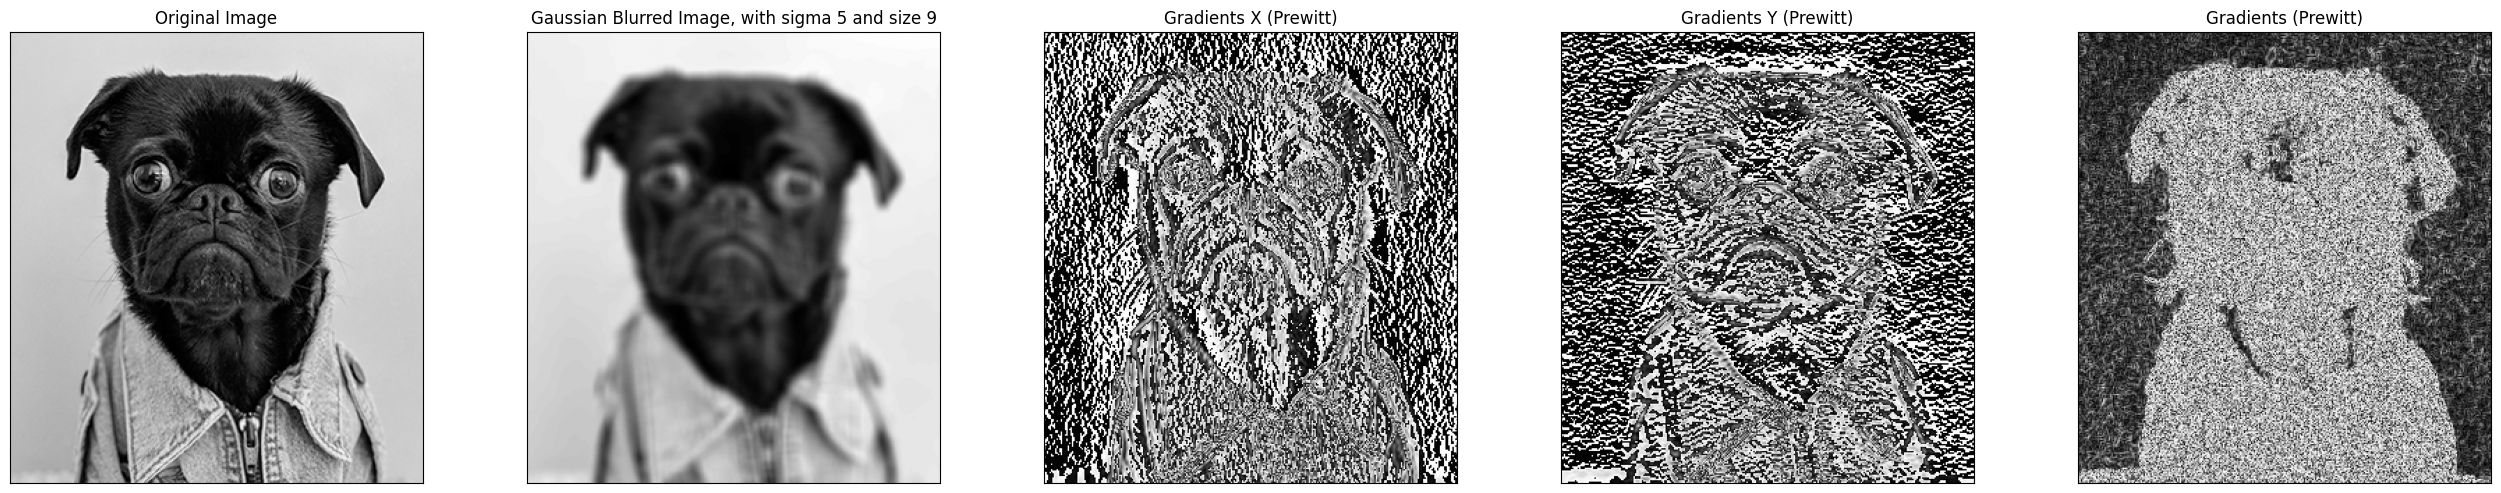

In [152]:
### DO NOT CHANGE ###
#@title Experiment with Image Gradients { run: "auto" }
if __name__ == "__main__":
    import numpy as np

    # custom exception
    class StopExecution(Exception):
        """Custom execution handler."""
        def _render_traceback_(self):
            """Suppress long exception message."""
            pass

    # custom print statements
    def printRB(text: str) -> None:
        """Prints red and bold."""
        red_bold = "\033[1;31m"
        reset = "\033[0m"
        print(f"{red_bold}{text}{reset}")

    # custom error handling
    def validate_numpy_implementation(
            expected_shape: tuple, function: str, **kwargs
        ) -> np.ndarray:
        """Does numpy-related validation and error handling.

        Args:
            expected_shape: expected shape of the numpy array
            function: string name of the function
            **kwargs: parameters for the function

        Returns:
            The numpy array result if all the validation checks pass
        """
        try:
            result = eval(function)(**kwargs)
            assert result is not None, (
                f"The `{function}` function does not have a return value"
            )
            assert isinstance(result, np.ndarray), (
                f"The `{function}` function does not return a numpy array"
            )
            assert result.shape == expected_shape, (
                f"The `{function}` function should return a numpy array "
                f"with shape {expected_shape} but found shape: {result.shape}"
            )
            assert not np.any(result == None), (
                f"The `{function}` function should return a numpy array "
                f"with only numeric data but found `None` values"
            )
        except NameError as e:
            printRB(
                "ERROR: It appears that the previous code cells "
                f"were not executed; please run the above cells!\n"
                f"Encounter exception with message: {e}"
            )
            raise StopExecution
        except Exception as e:
            printRB(
                f"ERROR: Required implementation for `{function}` "
                "is incorrect or incomplete\nCheck your solution "
                "with the provided examples or validate with Gradescope\n"
                f"Encounter exception with message: {e}"
            )
            raise StopExecution
        return result

    # download the images
    import os
    import gdown

    file_id = "15HWhYP_Kjbsz5AusTuuZtLi9nmTGiviY"
    img_filepath = "/content/sample_image.jpg"

    if not os.path.exists(img_filepath):
        try:
            gdown.download(
                f"https://drive.google.com/uc?id={file_id}",
                img_filepath, quiet=True
            )
        except Exception as e:
            printRB(
                "ERROR: Could not download the file; "
                f"encounter exception with message: {e}"
            )
            raise StopExecution

    # parameters
    s = 5 #@param { type: "slider", min: 1, max: 20, step: 1}
    n = 9 #@param { type: "slider", min: 3, max: 25, step: 2}
    gradient_kernel = "Prewitt" #@param ["Sobel", "Prewitt", "Roberts"]

    # process the image
    import cv2
    import matplotlib.pyplot as plt

    try:
        img = cv2.imread(img_filepath, cv2.IMREAD_COLOR)
    except Exception as e:
        printRB(
            "ERROR: Could not open the file; "
            f"encounter exception with message: {e}"
        )
        raise StopExecution

    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except Exception as e:
        printRB(
            "ERROR: Could not convert the image to grayscale; "
            f"encounter exception with message: {e}"
        )
        raise StopExecution


    kernel = validate_numpy_implementation(
        (n, n), "gaussian_kernel", s=s, n=n
    )
    gaussian_filtered_img = validate_numpy_implementation(
        img.shape, "convolve", img=img, kernel=kernel
    )

    if gradient_kernel == "Sobel":
        Ix = validate_numpy_implementation(
            img.shape, "gradients_x_sobel", img=img
        )
        Iy = validate_numpy_implementation(
            img.shape, "gradients_y_sobel", img=img
        )
    if gradient_kernel == "Prewitt":
        Ix = validate_numpy_implementation(
            img.shape, "gradients_x_prewitt", img=img
        )
        Iy = validate_numpy_implementation(
            img.shape, "gradients_y_prewitt", img=img
        )
    if gradient_kernel == "Roberts":
        Ix = validate_numpy_implementation(
            img.shape, "gradients_x_roberts", img=img
        )
        Iy = validate_numpy_implementation(
            img.shape, "gradients_y_roberts", img=img
        )

    G_magnitude = validate_numpy_implementation(
        img.shape, "gradient_magnitude", Ix=Ix, Iy=Iy
    )

    try:
        fig, ax = plt.subplots(1, 5, figsize=(26, 5))
        ax[0].imshow(img, cmap="gray")
        ax[0].set_title("Original Image")
        ax[1].imshow(gaussian_filtered_img, cmap="gray")
        ax[1].set_title(f"Gaussian Blurred Image, with sigma {s} and size {n}")
        ax[2].imshow(Ix, cmap="gray")
        ax[2].set_title(f"Gradients X ({gradient_kernel})")
        ax[3].imshow(Iy, cmap="gray")
        ax[3].set_title(f"Gradients Y ({gradient_kernel})")
        ax[4].imshow(G_magnitude, cmap="gray")
        ax[4].set_title(f"Gradients ({gradient_kernel})")
        for index, a in enumerate(ax):
            a.set_xticks([])
            a.set_yticks([])
    except Exception as e:
        print(f"ERROR: Encountered issue with visualizing the results: {e}")
        raise StopExecution

    plt.tight_layout()
    plt.show()

## Step 3: Non-Maximum Suppression (NMS) for Image Gradients (15 pts)

In this section, you'll implement functions for Step 3: Non-Maximum Suppression (NMS) for Image Gradients.

### Prep for NMS (5 pts)

The matrix that is returned from `gradient_direction` should be radians and have values between $-\pi$ to $\pi$. For our Non-Maximum Suppression algorithm, we want to first transform these values to degrees and make the range of values be from $0°$ to $180°$. Implement `prep_for_NMS` that takes the matrix returned from `gradient_direction` and applies those transformation. The input and output matrix will have the same shape.

**Hint**: To convert radians to degrees, use [`np.degrees`](https://numpy.org/doc/stable/reference/generated/numpy.degrees.html). To scale the values from $[-180°, 180°]$ to $[0°, 180°]$, add $180°$ to all the values that are less than $0°$ (this works due to the geometry / symmetry of angles).

#### Examples

##### Example 1

```python
M = np.array([
    [-1.892, -2.158, -1.892],
    [-1.735, -1.892, -1.735],
    [-1.892, -2.158, -1.892]
])

prep_for_NMS(M) = np.array([
    [71.59638516124825, 56.35570781076835, 71.59638516124825],
    [80.59182254480217, 71.59638516124825, 80.59182254480217],
    [71.59638516124825, 56.35570781076835, 71.59638516124825]
])
```

**Explanation**: Convert each entry in `M` from radians to degrees. Any values that are negative, add 180 to them.


##### Example 2

```python
M = np.array([
    [-1.815, -2.034, -2.034, -1.815],
    [-1.695, -1.815, -1.815, -1.695],
    [-1.815, -2.034, -2.034, -1.815]
])

prep_for_NMS(M) = np.array([
    [76.00816018375559, 63.46038447039056, 63.46038447039056, 76.00816018375559],
    [82.88365372532546, 76.00816018375559, 76.00816018375559, 82.88365372532546],
    [76.00816018375559, 63.46038447039056, 63.46038447039056, 76.00816018375559]
])
```

**Explanation**: Convert each entry in `M` from radians to degrees. Any values that are negative, add 180 to them.


#### <mark>Implementation</mark>

In [153]:
def prep_for_NMS(M: np.ndarray) -> np.ndarray:
    Mdeg = np.degrees(M)
    Mdeg[Mdeg < 0] += 180

    return Mdeg

### NMS (10 pts)

Given the gradient magnitude matrix returned from the function `gradient_magnitude`, `G_magnitude`, and the transformed gradient angle matrix returned from the function `prep_for_NMS`, `G_angle`, perform non-maximum suppression. Both input matrices will have same shape. The output should be a matrix of the same shape, as well. The output matrix should have the gradient value from `G_magnitude` if that gradient value is maximal along its direction, otherwise it should be set to 0.

The non-maximum suppression algorithm is:
- Gradient angles in $[0°, 22.5°)$ or $[157.5°, 180°]$ will map to $0°$ meaning the gradient points along the east and west direction; thus the gradient value of the pixel should be compared with its east and west neighbor; if it's greater than it's east and west neighbor, it stays, otherwise it's suppressed and it's gradient value goes to zero.
- Gradient angles in $[22.5°, 67.5°)$ will map to $45°$ meaning the gradient points along the north-east and south-west direction; thus the gradient value of the pixel should be compared with its north-east and south-west neighbor; if it's greater than it's north-east and south-west neighbor, it stays, otherwise it's suppressed and it's gradient value goes to zero.
- Gradient angles in $[67.5°, 112.5°)$ will map to $90°$ meaning the gradient points along the north and south direction; thus the gradient value of the pixel should be compared with its north and south neighbor; if it's greater than it's north and south neighbor, it stays, otherwise it's suppressed and it's gradient value goes to zero.
- Gradient angles in $[112.5°, 157.5°)$ will map to $135°$ meaning the gradient points along the north-west and south-east direction; thus the gradient value of the pixel should be compared with its north-west and south-east neighbor; if it's greater than it's north-west and south-east neighbor, it stays, otherwise it's suppressed and it's gradient value goes to zero.

Note: in this implementation, when we think about a pixel's neighbors, we are look at the $3 \times 3$ window about the pixel (where the pixel is in the center). However, we can also implement this by looking at a bigger window of neighbors such as a $5\times5$ window. For this implementation. we'll only stick with the $3 \times 3$ window.

Note: for handling the gradients at the border, where gradient values need to be compared with gradient values that fall outside the image boundary, you can assume that there is no gradient values outside the gradient matrix (i.e., a comparsion is not needed).

**Hint**: Loop through the gradients magnitude and angles and compare the neighbors accordingly (using if-else statements).

#### Examples

##### Example 1

```python
G_magnitude = np.array([
    [12.649, 14.422, 12.649],
    [24.331, 25.298, 24.331],
    [12.649, 14.422, 12.649]
])
G_angle = np.array([
    [71.596, 56.355, 71.596],
    [80.591, 71.596, 80.591],
    [71.596, 56.355, 71.596]
])

NMS(G_magnitude, G_angle) = np.array([
    [   0.0,    0.0,    0.0],
    [24.331, 25.298, 24.331],
    [   0.0,    0.0,    0.0]
])
```

**Explanation**: For each pixel, look at the value in `G_angle` to determine which neighbors to compare. Then look at the magnitudes in `G_magnitude` and if the pixel value is greater than the neighbors to compare, keep the value, otherwise suppress to zero.

For example, the top left corner pixel has an angle value of 71.596 so we compare the north and south neighbors. There is no north neighbor so we only need to compare with the south neighbor. Since the magnitude for the top left corner is 12.649 and its south neighbor's magnitude is 24.331, which is greater, the pixel is suppressed to zero.

Another example is the center pixel which has an angle value of 71.596 so we compare the north and south neighbors. Since the magnitude for the center is 25.298 and its north and south neighbors magnitude is 14.422, which is smaller, the pixel is not suppressed and the magnitude value is kept in the resulting matrix.

##### Example 2

```python
G_magnitude = np.array([
    [46.492, 17.888, 17.888, 16.492],
    [32.249, 32.984, 32.984, 32.249],
    [16.492, 17.888, 17.888, 16.492]
])
G_angle = np.array([
    [116.008, 63.46, 63.46, 76.008],
    [82.883, 76.008, 176.008, 82.883],
    [76.008, 63.46, 63.46, 76.008]
])

NMS(G_magnitude, G_angle) = np.array([
    [46.492, 0.0, 0.0, 0.0],
    [0.0, 32.984, 0.0, 32.249],
    [0.0, 0.0, 0.0, 0.0],
])
```

**Explanation**: For each pixel, look at the value in `G_angle` to determine which neighbors to compare. Then look at the magnitudes in `G_magnitude` and if the pixel value is greater than the neighbors to compare, keep the value, otherwise suppress to zero.

For example, the top left corner pixel has an angle value of 116.008 so we compare the north-west and south-east neighbors. There is no north-west neighbor so we only need to compare with the south-east neighbor. Since the magnitude for the top left corner is 46.492 and its south-east neighbor's magnitude is 32.984, which is smaller, the pixel is not suppressed and the magnitude value is kept in the resulting matrix.

Another example is the third middle pixel (from the left) which has an angle value of 176.008 so we compare the east and west neighbors. The magnitude for the third middle pixel is 32.984, its east neighbor's magnitude is 32.984, which is the same, and its west neighbor's magnitude is 32.249, which is smaller. Since the pixel magnitude is not greater than its neighbors, it is suppressed to zero.

#### <mark>Implementation</mark>

In [179]:
def NMS(G_magnitude: np.ndarray, G_angle: np.ndarray) -> np.ndarray:
    H, W = G_magnitude.shape
    output = np.zeros((H, W))

    for i in range(H):
        for j in range(W):
            current_angle = G_angle[i, j]
            current_mag = G_magnitude[i, j]

            # Set neighbors to a low number if out of bounds
            n1 = n2 = -np.inf

            if (0 <= current_angle < 22.5) or (157.5 <= current_angle < 180):
                if j > 0:
                    n1 = G_magnitude[i, j - 1]
                if j < W - 1:
                    n2 = G_magnitude[i, j + 1]

            elif 22.5 <= current_angle < 67.5:
                if i > 0 and j < W - 1:
                    n1 = G_magnitude[i - 1, j + 1]
                if i < H - 1 and j > 0:
                    n2 = G_magnitude[i + 1, j - 1]

            elif 67.5 <= current_angle < 112.5:
                if i > 0:
                    n1 = G_magnitude[i - 1, j]
                if i < H - 1:
                    n2 = G_magnitude[i + 1, j]

            elif 112.5 <= current_angle < 157.5:
                if i > 0 and j > 0:
                    n1 = G_magnitude[i - 1, j - 1]
                if i < H - 1 and j < W - 1:
                    n2 = G_magnitude[i + 1, j + 1]

            # Keep only if greater than both neighbors
            if current_mag > n1 and current_mag > n2:
                output[i, j] = current_mag
            else:
                output[i, j] = 0.0

    return output

G_magnitude = np.array([
    [46.492, 17.888, 17.888, 16.492],
    [32.249, 32.984, 32.984, 32.249],
    [16.492, 17.888, 17.888, 16.492]
])
G_angle = np.array([
    [116.008, 63.46, 63.46, 76.008],
    [82.883, 76.008, 176.008, 82.883],
    [76.008, 63.46, 63.46, 76.008]
])

NMS(G_magnitude, G_angle)

array([[46.492,  0.   ,  0.   ,  0.   ],
       [ 0.   , 32.984,  0.   , 32.249],
       [ 0.   ,  0.   ,  0.   ,  0.   ]])

### Non-Maximum Suppression Demo

After implementing all of the above functions, you can experiment with / visualize the gradients after non-maximum suppression on a sample image. Feel free to experiment with the various parameters as well.

**Note**: Make sure to run all of the above cells in order for the demo to work as it assumes that the previous cells were ran. Additionally, validate your implementations are working, either by manually testing with the examples or automatically testing by submitting on Gradescope (which will run the example test cases and give feedback). The demo uses your implementations so errors in your implementation can cause the demo to not work. The demo also tries to give useful hints or pointers if there are issues on what the issue might be (however it may not always be accurate or perfect). If there are questions or issues, please reach out to the course staff by posting on Ed.

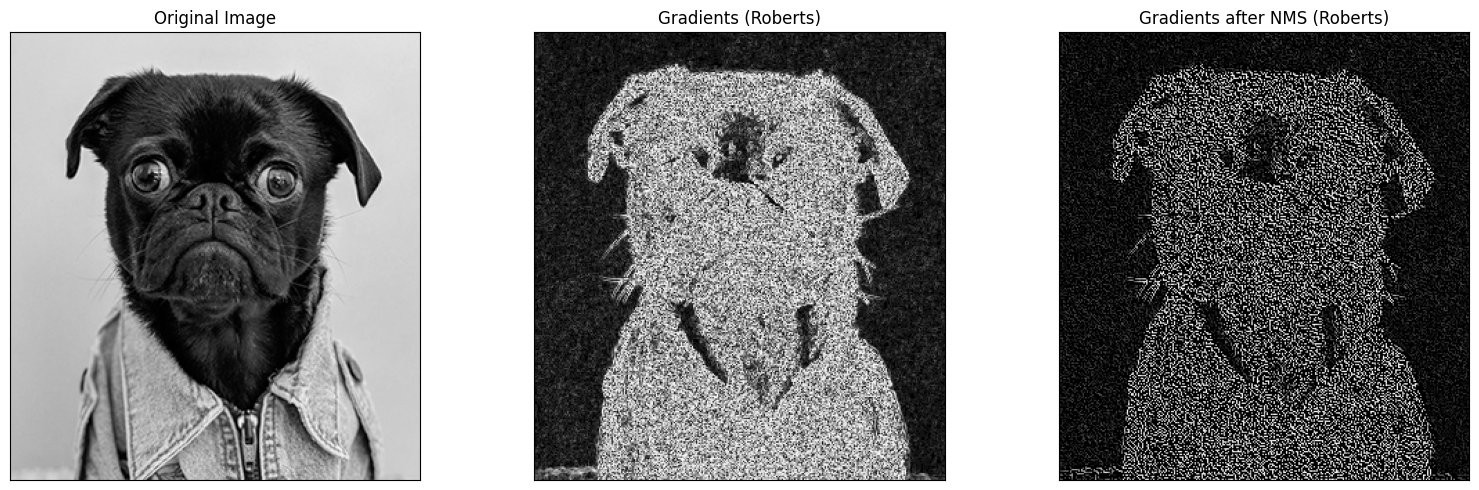

In [155]:
### DO NOT CHANGE ###
#@title Experiment with Non-Maximum Suppression { run: "auto" }
if __name__ == "__main__":
    import numpy as np

    # custom exception
    class StopExecution(Exception):
        """Custom execution handler."""
        def _render_traceback_(self):
            """Suppress long exception message."""
            pass

    # custom print statements
    def printRB(text: str) -> None:
        """Prints red and bold."""
        red_bold = "\033[1;31m"
        reset = "\033[0m"
        print(f"{red_bold}{text}{reset}")

    # custom error handling
    def validate_numpy_implementation(
            expected_shape: tuple, function: str, **kwargs
        ) -> np.ndarray:
        """Does numpy-related validation and error handling.

        Args:
            expected_shape: expected shape of the numpy array
            function: string name of the function
            **kwargs: parameters for the function

        Returns:
            The numpy array result if all the validation checks pass
        """
        try:
            result = eval(function)(**kwargs)
            assert result is not None, (
                f"The `{function}` function does not have a return value"
            )
            assert isinstance(result, np.ndarray), (
                f"The `{function}` function does not return a numpy array"
            )
            assert result.shape == expected_shape, (
                f"The `{function}` function should return a numpy array "
                f"with shape {expected_shape} but found shape: {result.shape}"
            )
            assert not np.any(result == None), (
                f"The `{function}` function should return a numpy array "
                f"with only numeric data but found `None` values"
            )
        except NameError as e:
            printRB(
                "ERROR: It appears that the previous code cells "
                f"were not executed; please run the above cells!\n"
                f"Encounter exception with message: {e}"
            )
            raise StopExecution
        except Exception as e:
            printRB(
                f"ERROR: Required implementation for `{function}` "
                "is incorrect or incomplete\nCheck your solution "
                "with the provided examples or validate with Gradescope\n"
                f"Encounter exception with message: {e}"
            )
            raise StopExecution
        return result

    # download the images
    import os
    import gdown

    file_id = "15HWhYP_Kjbsz5AusTuuZtLi9nmTGiviY"
    img_filepath = "/content/sample_image.jpg"

    if not os.path.exists(img_filepath):
        try:
            gdown.download(
                f"https://drive.google.com/uc?id={file_id}",
                img_filepath, quiet=True
            )
        except Exception as e:
            printRB(
                "ERROR: Could not download the file; "
                f"encounter exception with message: {e}"
            )
            raise StopExecution

    # parameters
    s = 5 #@param { type: "slider", min: 1, max: 20, step: 1}
    n = 9 #@param { type: "slider", min: 3, max: 25, step: 2}
    gradient_kernel = "Roberts" #@param ["Sobel", "Prewitt", "Roberts"]

    # process the image
    import cv2
    import matplotlib.pyplot as plt

    try:
        img = cv2.imread(img_filepath, cv2.IMREAD_COLOR)
    except Exception as e:
        printRB(
            "ERROR: Could not open the file; "
            f"encounter exception with message: {e}"
        )
        raise StopExecution

    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except Exception as e:
        printRB(
            "ERROR: Could not convert the image to grayscale; "
            f"encounter exception with message: {e}"
        )
        raise StopExecution


    kernel = validate_numpy_implementation(
        (n, n), "gaussian_kernel", s=s, n=n
    )
    gaussian_filtered_img = validate_numpy_implementation(
        img.shape, "convolve", img=img, kernel=kernel
    )

    if gradient_kernel == "Sobel":
        Ix = validate_numpy_implementation(
            img.shape, "gradients_x_sobel", img=img
        )
        Iy = validate_numpy_implementation(
            img.shape, "gradients_y_sobel", img=img
        )
    if gradient_kernel == "Prewitt":
        Ix = validate_numpy_implementation(
            img.shape, "gradients_x_prewitt", img=img
        )
        Iy = validate_numpy_implementation(
            img.shape, "gradients_y_prewitt", img=img
        )
    if gradient_kernel == "Roberts":
        Ix = validate_numpy_implementation(
            img.shape, "gradients_x_roberts", img=img
        )
        Iy = validate_numpy_implementation(
            img.shape, "gradients_y_roberts", img=img
        )

    G_magnitude = validate_numpy_implementation(
        img.shape, "gradient_magnitude", Ix=Ix, Iy=Iy
    )
    G_angle = validate_numpy_implementation(
        img.shape, "gradient_direction", Ix=Ix, Iy=Iy
    )
    prepped_G_angle = validate_numpy_implementation(
        img.shape, "prep_for_NMS", M=G_angle
    )
    G_magnitude_NMS = validate_numpy_implementation(
        img.shape, "NMS",
        G_magnitude=G_magnitude, G_angle=prepped_G_angle
    )


    try:
        fig, ax = plt.subplots(1, 3, figsize=(16, 5))
        ax[0].imshow(img, cmap="gray")
        ax[0].set_title("Original Image")
        ax[1].imshow(G_magnitude, cmap="gray")
        ax[1].set_title(f"Gradients ({gradient_kernel})")
        ax[2].imshow(G_magnitude_NMS, cmap="gray")
        ax[2].set_title(f"Gradients after NMS ({gradient_kernel})")
        for index, a in enumerate(ax):
            a.set_xticks([])
            a.set_yticks([])
    except Exception as e:
        print(f"ERROR: Encountered issue with visualizing the results: {e}")
        raise StopExecution

    plt.tight_layout()
    plt.show()

## Step 4: Two-Stage Hysteresis (10 pts)

In this section, you'll implement functions for Step 4: Two-Stage Hysteresis.

### Two Stage Hysteresis (10 pts)

The input into this function will be the gradient magnitude matrix, after applying non-maximal suppression (`NMS`) and being scaled (`rescale_matrix`) (i.e., assume those steps have already been done so no need to do them inside the function). The values in the input matrix, `M`, will take values between 0 to 1 inclusive. Given a `high_threshold` and `low_threshold` where `high_threshold` > `low_threshold`, perform two-stage hysteresis on the matrix `M`. The `high_threshold` and `low_threshold` parameters will be float numbers between `0` and `1`. The output should a binary matrix the same shape as `M` where `0` represents no edge and `1` represents an edge.

To recap, the algorithm for two-stage hysyeresis is:
- If a pixel value's gradient is above `high_threshold`, it's a strong edge and is kept (goes to one in the final binary image matrix).
- If a pixel value's gradient is less than the `low_threshold`, then it's suppressed (goes to zero in the final binary image matrix).
- If a pixel value's is between the `low_threshold` and `high_threshold` inclusive, then it's considered a weak edge. A weak edge will only remain if one of it's adjacent neigbors (for this implementation, it is the $3 \times 3$ window centered on the pixel) is marked as a strong edge (goes to one in the final binary image matrix). Otherwise, it's suppressed.

Note: for handling the gradients at the border, where gradient values need to be compared with gradient values that fall outside the image boundary, you can assume that the gradient values outside the gradient matrix (i.e., a comparsion is not needed).

In the end, the pixel values that correspond to an edge will stay and everything else will go to zero. In the end, we'll be left with a binary map of which pixels correspond to edges.

**Hint**: Loop through the matrix and compare the gradient values accordingly (using if-else statements).


#### Examples

##### Example 1

```python
M = np.array([
    [0.0, 0.5, 0.1],
    [0.4, 0.0, 0.1],
    [0.4, 0.0, 0.2]
])
low_threshold = 0.15
high_threshold = 0.45

two_stage_hysteresis(M, low_threshold, high_threshold) = np.array([
    [0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0]
])
```

**Explanation**: For the entries in `M` that are greater than the `high_thresold`, it becomes 1. For entries in `M` between the `low_threshold` and `high_threshold`, it becomes 1 if any of it's neighbors are above the `high_threshold`. Everything else becomes 0.

##### Example 2

```python
M = np.array([
    [0.3, 0.2, 0.2, 0.2],
    [0.0, 0.1, 0.2, 0.1],
    [0.5, 0.3, 0.2, 0.1]
])
low_threshold = 0.25
high_threshold = 0.45

two_stage_hysteresis(M, low_threshold, high_threshold) = np.array([
    [0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 0.0]
])
```

**Explanation**: For the entries in `M` that are greater than the `high_thresold`, it becomes 1. For entries in `M` between the `low_threshold` and `high_threshold`, it becomes 1 if any of it's neighbors are above the `high_threshold`. Everything else becomes 0.

#### <mark>Implementation</mark>

In [192]:
def two_stage_hysteresis(M: np.ndarray, low_threshold: float, high_threshold: float) -> np.ndarray:
    H, W = M.shape
    output = np.zeros((H, W))

    for i in range(H):
      for j in range(W):

        if M[i, j] >= high_threshold:
            output[i, j] = 1

        elif M[i, j] >= low_threshold:
            output[i, j] = 0.5 # Weak edge

    for i in range(H):
        for j in range(W):
             if output[i, j] == 0.5:
                has_strong_neighbor = False
                for di in [-1, 0, 1]:
                    for dj in [-1, 0, 1]:
                        ni, nj = i + di, j + dj
                        if 0 <= ni < H and 0 <= nj < W:
                            if output[ni, nj] == 1:
                                has_strong_neighbor = True
                                break
                    if has_strong_neighbor:
                        break
                if has_strong_neighbor:
                    # Make sure promoted edges don't promote new edges
                    output[i, j] = 0.9 # Promoted edge

    output[output == 0.9] = 1
    output[output == 0.5] = 0

    return output

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [1., 1., 0., 0.]])

## Canny Edge Detection Demo

**Congrats on implementing the Canny Edge Detection algorithm**. In this section, you can experiment / demo with the algorithm by tuning / changing all the available parameters.

**Note**: Make sure to run all of the above cells in order for the demo to work as it assumes that the previous cells were ran. Additionally, validate your implementations are working, either by manually testing with the examples or automatically testing by submitting on Gradescope (which will run the example test cases and give feedback). The demo uses your implementations so errors in your implementation can cause the demo to not work. The demo also tries to give useful hints or pointers if there are issues on what the issue might be (however it may not always be accurate or perfect). If there are questions or issues, please reach out to the course staff by posting on Ed.

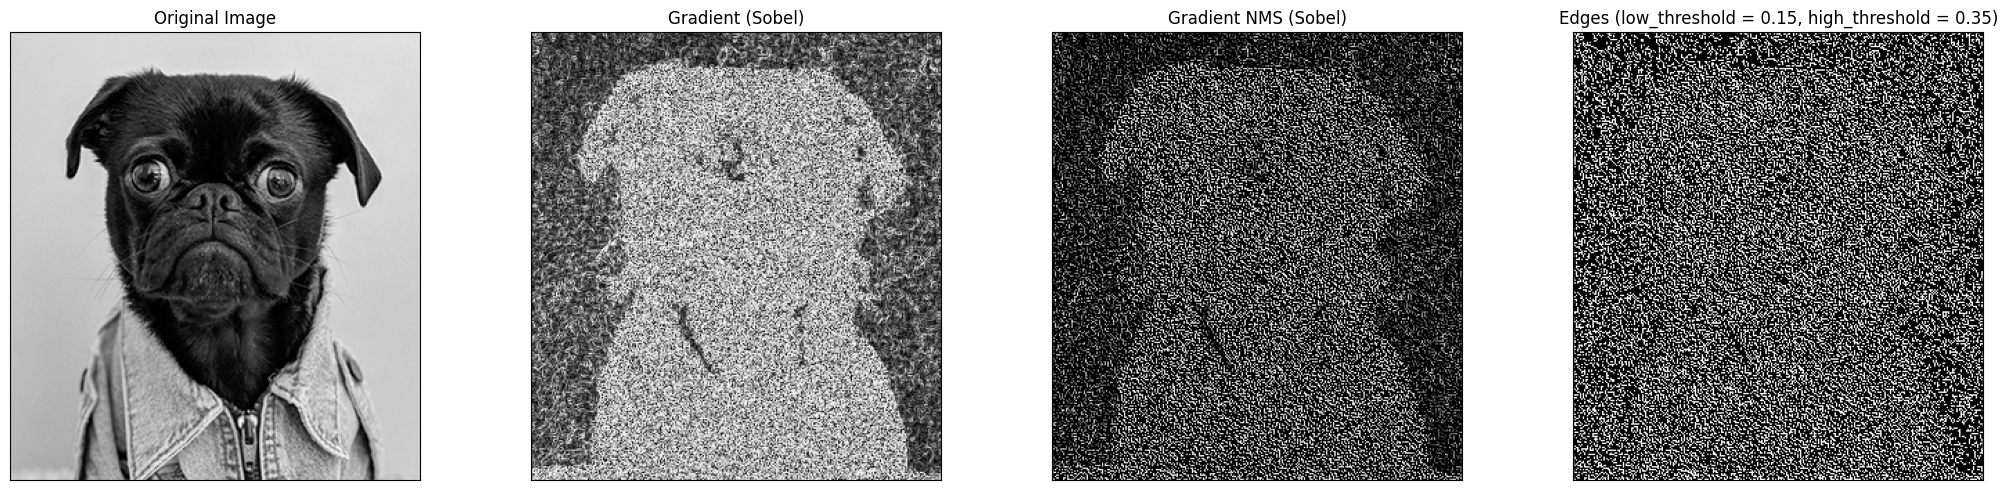

In [198]:
### DO NOT CHANGE ###
#@title Experiment with the Canny Edge Detection Algorithm { run: "auto" }
if __name__ == "__main__":
    import numpy as np

    # custom exception
    class StopExecution(Exception):
        """Custom execution handler."""
        def _render_traceback_(self):
            """Suppress long exception message."""
            pass

    # custom print statements
    def printRB(text: str) -> None:
        """Prints red and bold."""
        red_bold = "\033[1;31m"
        reset = "\033[0m"
        print(f"{red_bold}{text}{reset}")

    # custom error handling
    def validate_numpy_implementation(
            expected_shape: tuple, function: str, **kwargs
        ) -> np.ndarray:
        """Does numpy-related validation and error handling.

        Args:
            expected_shape: expected shape of the numpy array
            function: string name of the function
            **kwargs: parameters for the function

        Returns:
            The numpy array result if all the validation checks pass
        """
        try:
            result = eval(function)(**kwargs)
            assert result is not None, (
                f"The `{function}` function does not have a return value"
            )
            assert isinstance(result, np.ndarray), (
                f"The `{function}` function does not return a numpy array"
            )
            assert result.shape == expected_shape, (
                f"The `{function}` function should return a numpy array "
                f"with shape {expected_shape} but found shape: {result.shape}"
            )
            assert not np.any(result == None), (
                f"The `{function}` function should return a numpy array "
                f"with only numeric data but found `None` values"
            )
        except NameError as e:
            printRB(
                "ERROR: It appears that the previous code cells "
                f"were not executed; please run the above cells!\n"
                f"Encounter exception with message: {e}"
            )
            raise StopExecution
        except Exception as e:
            printRB(
                f"ERROR: Required implementation for `{function}` "
                "is incorrect or incomplete\nCheck your solution "
                "with the provided examples or validate with Gradescope\n"
                f"Encounter exception with message: {e}"
            )
            raise StopExecution
        return result

    # download the images
    import os
    import gdown

    file_id = "15HWhYP_Kjbsz5AusTuuZtLi9nmTGiviY"
    img_filepath = "/content/sample_image.jpg"

    if not os.path.exists(img_filepath):
        try:
            gdown.download(
                f"https://drive.google.com/uc?id={file_id}",
                img_filepath, quiet=True
            )
        except Exception as e:
            printRB(
                "ERROR: Could not download the file; "
                f"encounter exception with message: {e}"
            )
            raise StopExecution

    # parameters
    s = 9 #@param { type: "slider", min: 1, max: 20, step: 1}
    n = 17 #@param { type: "slider", min: 3, max: 25, step: 2}
    gradient_kernel = "Sobel" #@param ["Sobel", "Prewitt", "Roberts"]
    low_threshold = 0.15 #@param {type:"number"}
    high_threshold = 0.45 #@param {type:"number"}

    if not (0 <= low_threshold <= 1):
        print(f"ERROR: Input `low_threshold` not valid number between 0 to 1; found `low_threshold` = {low_threshold}")
        raise StopExecution

    if not (0 <= high_threshold <= 1):
        print(f"ERROR: Input `high_threshold` not valid number between 0 to 1; found `high_threshold` = {high_threshold}")
        raise StopExecution

    if low_threshold > high_threshold:
        print(f"ERROR: Input `low_threshold` is higher than `high_threshold`; found `low_threshold` = {low_threshold} and `high_threshold` = {high_threshold}")
        raise StopExecution

    # process the image
    import cv2
    import matplotlib.pyplot as plt

    try:
        img = cv2.imread(img_filepath, cv2.IMREAD_COLOR)
    except Exception as e:
        printRB(
            "ERROR: Could not open the file; "
            f"encounter exception with message: {e}"
        )
        raise StopExecution

    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except Exception as e:
        printRB(
            "ERROR: Could not convert the image to grayscale; "
            f"encounter exception with message: {e}"
        )
        raise StopExecution


    kernel = validate_numpy_implementation(
        (n, n), "gaussian_kernel", s=s, n=n
    )
    gaussian_filtered_img = validate_numpy_implementation(
        img.shape, "convolve", img=img, kernel=kernel
    )

    if gradient_kernel == "Sobel":
        Ix = validate_numpy_implementation(
            img.shape, "gradients_x_sobel", img=img
        )
        Iy = validate_numpy_implementation(
            img.shape, "gradients_y_sobel", img=img
        )
    if gradient_kernel == "Prewitt":
        Ix = validate_numpy_implementation(
            img.shape, "gradients_x_prewitt", img=img
        )
        Iy = validate_numpy_implementation(
            img.shape, "gradients_y_prewitt", img=img
        )
    if gradient_kernel == "Roberts":
        Ix = validate_numpy_implementation(
            img.shape, "gradients_x_roberts", img=img
        )
        Iy = validate_numpy_implementation(
            img.shape, "gradients_y_roberts", img=img
        )

    G_magnitude = validate_numpy_implementation(
        img.shape, "gradient_magnitude", Ix=Ix, Iy=Iy
    )
    G_angle = validate_numpy_implementation(
        img.shape, "gradient_direction", Ix=Ix, Iy=Iy
    )
    prepped_G_angle = validate_numpy_implementation(
        img.shape, "prep_for_NMS", M=G_angle
    )
    G_magnitude_NMS = validate_numpy_implementation(
        img.shape, "NMS",
        G_magnitude=G_magnitude, G_angle=prepped_G_angle
    )

    G_magnitude_NMS_scaled = validate_numpy_implementation(
        img.shape, "rescale_matrix", M=G_magnitude_NMS
    )
    edges = validate_numpy_implementation(
        img.shape, "two_stage_hysteresis",
        M=G_magnitude_NMS_scaled,
        low_threshold=low_threshold,
        high_threshold=high_threshold
    )

    try:
        fig, ax = plt.subplots(1, 4, figsize=(21, 5))
        ax[0].imshow(img, cmap="gray")
        ax[0].set_title("Original Image")
        ax[1].imshow(G_magnitude, cmap="gray")
        ax[1].set_title(f"Gradient ({gradient_kernel})")
        ax[2].imshow(G_magnitude_NMS, cmap="gray")
        ax[2].set_title(f"Gradient NMS ({gradient_kernel})")
        ax[3].imshow(edges, cmap="gray")
        ax[3].set_title(f"Edges (low_threshold = {low_threshold:.2f}, high_threshold = {high_threshold:.2f})")
        for index, a in enumerate(ax):
            a.set_xticks([])
            a.set_yticks([])
    except Exception as e:
        print(f"ERROR: Encountered issue with visualizing the results: {e}")
        raise StopExecution

    plt.tight_layout()
    plt.show()

## Problem Set Survey (5 pts)

Please fill out the survey questions (the first five are each worth 1 point; the last one is optional).


1.   `TIME` (1 pt): approximately how many hours did you spend on the problem set? Please use decimals to express partial hours (e.g., a value of `2.5` means two and half hours).
2.   `DIFFICULTY` (1 pt): on a scale of 1-10, how difficult was this problem set with 1 being very easy and 10 being very hard?
3.   `FAVORITE_PART` (1 pt): What was your favorite topic / learning from the unit (i.e., between the last pset and this pset)? This should contain at least 10 words.
4.   `WENT_WELL` (1 pt): What went well? Describe what went well with the course so far (this can be about the lecture, assignments, and/or other course content). This should contain at least 10 words.
5.   `CHALLENGING` (1 pt): What was challenging? Describe what was challenging or didn't go well with the course so far (this can be about the lecture, assignments, and/or other course content). This should contain at least 10 words.
6.   `COMMENTARY` (0 pt): If there is anything else you'd like to share with course staff, please add it here. You can also mention any resources you used (include generative AI) or any students you collaborated with here as well. If there is nothing to share, no need to change / edit the default value.

In [158]:
#@title Problem Set Survey Questions
TIME = "5" #@param {type:"string"}

DIFFICULTY = "8" #@param ["", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

FAVORITE_PART = "My favorite topic was the different kernels and how they handled image detection differently." #@param {type:"string"}

WENT_WELL = "I was able to write most of the code and it felt satisfying when I was able to see my code work with the image detection." #@param {type:"string"}

CHALLENGING = "Some of the code was quite difficult for me to grasp when first reading the assignment(NMS mainly)" #@param {type:"string"}

COMMENTARY = "Used genAI for NMS and Two-Stage Hysteresis" #@param {type:"string"}

**<font color='red'>To submit, please download as a Python (.py) file and submit on Gradescope (navigate to File > Download > Download .py). Please use the correct file name and comment out any test / extraneous code to avoid any compile and parser issues </font>**